# Twitter Community Notes Data Sampler

This notebook is used to extract sample data from large TSV files for quick exploration and topic model testing.

## Objectives:
- Randomly extract 10,000-50,000 rows from each TSV file
- Control sample file size to be within 50-100MB
- Prepare appropriately sized data for topic modeling

In [2]:
!pip list
import sys
print(sys.executable)

Package                                           Version
------------------------------------------------- -----------
apispec                                           6.8.1
blinker                                           1.9.0
BTM                                               1.1.5
certifi                                           2025.1.31
charset-normalizer                                3.4.1
click                                             8.1.8
contourpy                                         1.3.1
cycler                                            0.12.1
Flask                                             3.1.0
flask-smorest                                     0.45.0
Flask-SQLAlchemy                                  3.1.1
fonttools                                         4.55.3
gensim                                            4.3.3
idna                                              3.10
itsdangerous                                      2.2.0
Jinja2                            

In [14]:
import os
import pandas as pd
import numpy as np
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)  # a seed to render the sample files deterministic 

# Set more attractive chart styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

## 1. Configuration Parameters

First, set the input and output paths, as well as sampling parameters

In [15]:
# Configure paths - Modify this to match your folder structure
RAW_DATA_DIR = os.path.expanduser("/Users/yunkaili/spring2025/NLP/project/raw")
OUTPUT_DIR = os.path.expanduser("/Users/yunkaili/spring2025/NLP/project/samples")

# Create output directory (if it doesn't exist)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Sampling parameters
MIN_SAMPLE_ROWS = 10000  # Minimum sample rows
MAX_SAMPLE_ROWS = 50000  # Maximum sample rows
TARGET_SAMPLE_SIZE_MB = 75  # Target sample size (MB)
MAX_SAMPLE_SIZE_MB = 100  # Maximum sample size (MB)

## 2. Find All TSV Files

In [16]:
# Find all TSV files
tsv_files = glob.glob(os.path.join(RAW_DATA_DIR, "*.tsv"))

print(f"Found {len(tsv_files)} TSV files:")
for i, file in enumerate(tsv_files):
    file_size_mb = os.path.getsize(file) / (1024 * 1024)
    print(f"{i+1}. {os.path.basename(file)} ({file_size_mb:.2f} MB)")

Found 4 TSV files:
1. ratings-00003.tsv (2351.74 MB)
2. noteStatusHistory-00000.tsv (460.65 MB)
3. notes-00000.tsv (819.35 MB)
4. userEnrollment-00000.tsv (114.58 MB)


## 3. Define Sampling Function

This function will automatically determine how to best sample from large files

In [17]:
def create_sample(file_path, output_path, min_rows=MIN_SAMPLE_ROWS, max_rows=MAX_SAMPLE_ROWS, 
                   target_size_mb=TARGET_SAMPLE_SIZE_MB, max_size_mb=MAX_SAMPLE_SIZE_MB):
    """
    Create an appropriately sized sample file from a TSV file
    - If the original file is not large, directly use all rows less than the maximum row count
    - For large files, first estimate the average size per row, then sample an appropriate number of rows
    """
    file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"Processing file: {os.path.basename(file_path)} ({file_size_mb:.2f} MB)")
    
    # 1. First calculate the total number of rows in the file
    total_rows = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        for _ in tqdm(f, desc="Calculating total rows"):
            total_rows += 1
    
    print(f"Total rows in file: {total_rows}")
    
    # 2. Estimate average row size
    avg_row_size_bytes = (file_size_mb * 1024 * 1024) / total_rows
    print(f"Average row size: {avg_row_size_bytes:.2f} bytes")
    
    # 3. Calculate target row count, keeping it between min and max row counts
    target_rows = int((target_size_mb * 1024 * 1024) / avg_row_size_bytes)
    sample_rows = min(max(target_rows, min_rows), max_rows)
    sample_rows = min(sample_rows, total_rows)  # Don't exceed total rows
    
    print(f"Will sample {sample_rows} rows (approx. {(sample_rows * avg_row_size_bytes)/(1024*1024):.2f} MB)")
    
    # 4. Decide sampling strategy based on file size
    if file_size_mb <= max_size_mb and total_rows <= max_rows:
        # Small file: read entire file
        print("File is small, keeping all data")
        df = pd.read_csv(file_path, sep='\t', low_memory=False)
        df.to_csv(output_path, sep='\t', index=False)
    else:
        # Large file: random sampling
        print("File is large, using random sampling")
        # Determine sampling method (chunking or random indices)
        if total_rows > 1000000:
            # Very large file: use chunked sampling
            sample_fraction = sample_rows / total_rows
            chunks = []
            
            for chunk in tqdm(pd.read_csv(file_path, sep='\t', chunksize=100000, low_memory=False),
                             desc="Sampling chunks"):
                chunk_sample = chunk.sample(frac=sample_fraction)
                chunks.append(chunk_sample)
            
            df = pd.concat(chunks)
            # If result exceeds required rows, sample again
            if len(df) > sample_rows:
                df = df.sample(n=sample_rows)
            
            df.to_csv(output_path, sep='\t', index=False)
        else:
            # Medium-sized file: use random row indices
            random_indices = sorted(np.random.choice(total_rows, size=sample_rows, replace=False))
            
            # Read header row (column names)
            header = pd.read_csv(file_path, sep='\t', nrows=0)
            header.to_csv(output_path, sep='\t', index=False)
            
            # Append sampled rows
            current_idx = 0
            with open(file_path, 'r', encoding='utf-8') as infile, \
                 open(output_path, 'a', encoding='utf-8') as outfile:
                # Skip header row
                next(infile)
                
                for i, line in tqdm(enumerate(infile), desc="Sampling random rows"):
                    if current_idx < len(random_indices) and i == random_indices[current_idx]:
                        outfile.write(line)
                        current_idx += 1
                        
                    # Exit loop if all sampled rows have been processed
                    if current_idx >= len(random_indices):
                        break
    
    # 5. Display result information
    sample_size_mb = os.path.getsize(output_path) / (1024 * 1024)
    print(f"Sample file saved: {os.path.basename(output_path)} ({sample_size_mb:.2f} MB)")
    print("-" * 80)
    
    return sample_size_mb

## 4. Process All TSV Files, Create Samples

In [18]:
# Create samples for each TSV file
sample_files = []
sample_sizes = []

for file_path in tsv_files:
    base_name = os.path.basename(file_path)
    output_path = os.path.join(OUTPUT_DIR, f"sample_{base_name}")
    
    sample_size = create_sample(file_path, output_path)
    
    sample_files.append(base_name)
    sample_sizes.append(sample_size)

Processing file: ratings-00003.tsv (2351.74 MB)


Calculating total rows: 0it [00:00, ?it/s]

Total rows in file: 13519069
Average row size: 182.41 bytes
Will sample 50000 rows (approx. 8.70 MB)
File is large, using random sampling


Sampling chunks: 0it [00:00, ?it/s]

Sample file saved: sample_ratings-00003.tsv (8.70 MB)
--------------------------------------------------------------------------------
Processing file: noteStatusHistory-00000.tsv (460.65 MB)


Calculating total rows: 0it [00:00, ?it/s]

Total rows in file: 1892440
Average row size: 255.24 bytes
Will sample 50000 rows (approx. 12.17 MB)
File is large, using random sampling


Sampling chunks: 0it [00:00, ?it/s]

Sample file saved: sample_noteStatusHistory-00000.tsv (12.35 MB)
--------------------------------------------------------------------------------
Processing file: notes-00000.tsv (819.35 MB)


Calculating total rows: 0it [00:00, ?it/s]

Total rows in file: 1750612
Average row size: 490.77 bytes
Will sample 50000 rows (approx. 23.40 MB)
File is large, using random sampling


Sampling chunks: 0it [00:00, ?it/s]

Sample file saved: sample_notes-00000.tsv (23.40 MB)
--------------------------------------------------------------------------------
Processing file: userEnrollment-00000.tsv (114.58 MB)


Calculating total rows: 0it [00:00, ?it/s]

Total rows in file: 1138361
Average row size: 105.54 bytes
Will sample 50000 rows (approx. 5.03 MB)
File is large, using random sampling


Sampling chunks: 0it [00:00, ?it/s]

Sample file saved: sample_userEnrollment-00000.tsv (5.03 MB)
--------------------------------------------------------------------------------


## 5. Sample Size Visualization

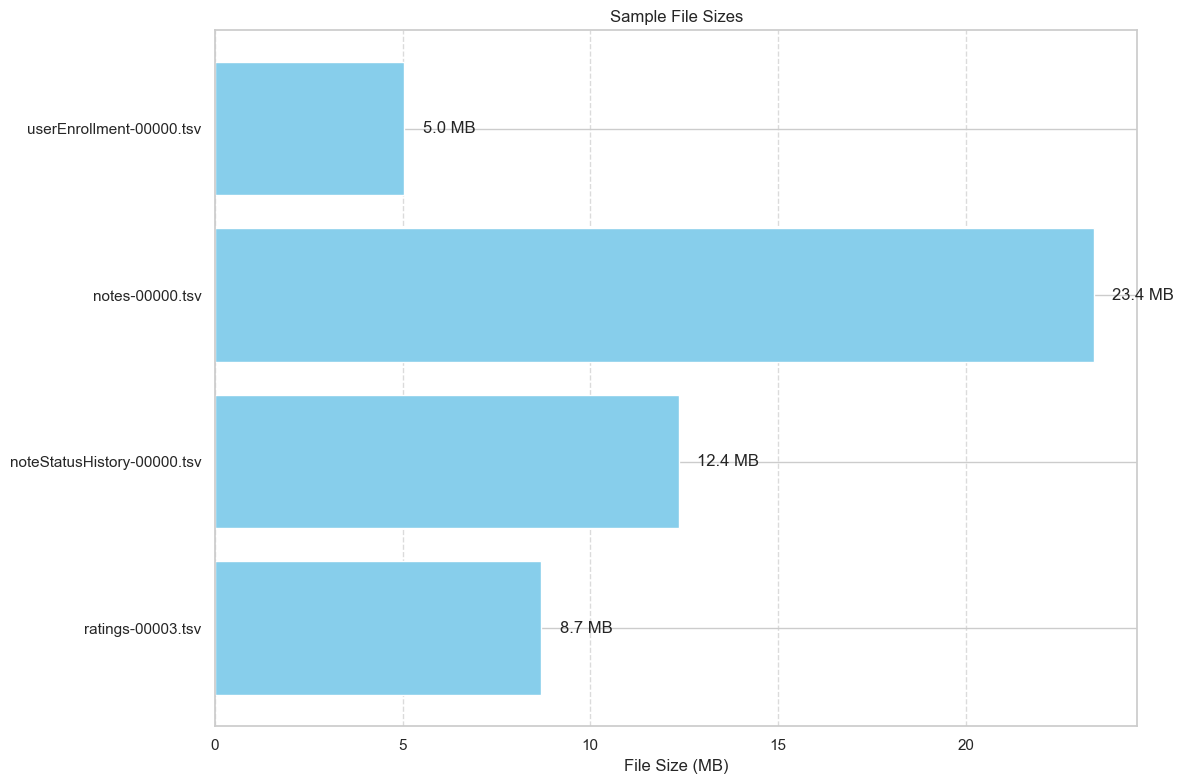

In [19]:
# Create sample size bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(sample_files, sample_sizes, color='skyblue')
plt.xlabel('File Size (MB)')
plt.title('Sample File Sizes')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f} MB',
            ha='left', va='center')

plt.tight_layout()
plt.show()

## 6. Perform Basic Statistical Analysis on Each Sample File

In [20]:
def analyze_sample(file_path):
    """
    Perform basic analysis on a sample file
    """
    print(f"Analyzing file: {os.path.basename(file_path)}")
    df = pd.read_csv(file_path, sep='\t', low_memory=False)
    
    # print(f"Row count: {len(df)}")
    print(f"Column count: {len(df.columns)}")
    print("\nColumn names:")
    for col in df.columns:
        print(f"- {col}")
    
    print("\nData types:")
    print(df.dtypes)
    
    print("\nFirst 5 rows:")
    display(df.head())
    
    print("\nMissing value statistics:")
    missing = df.isnull().sum()
    print(missing[missing > 0])
    
    print("-" * 80)
    
    return df

In [21]:
# Analyze the first sample file as an example
if len(sample_files) > 0:
    for i in range(len(sample_files)): 
        a_sample = os.path.join(OUTPUT_DIR, f"sample_{sample_files[i]}")
        sample_df = analyze_sample(a_sample)

Analyzing file: sample_ratings-00003.tsv
Column count: 32

Column names:
- noteId
- raterParticipantId
- createdAtMillis
- version
- agree
- disagree
- helpful
- notHelpful
- helpfulnessLevel
- helpfulOther
- helpfulInformative
- helpfulClear
- helpfulEmpathetic
- helpfulGoodSources
- helpfulUniqueContext
- helpfulAddressesClaim
- helpfulImportantContext
- helpfulUnbiasedLanguage
- notHelpfulOther
- notHelpfulIncorrect
- notHelpfulSourcesMissingOrUnreliable
- notHelpfulOpinionSpeculationOrBias
- notHelpfulMissingKeyPoints
- notHelpfulOutdated
- notHelpfulHardToUnderstand
- notHelpfulArgumentativeOrBiased
- notHelpfulOffTopic
- notHelpfulSpamHarassmentOrAbuse
- notHelpfulIrrelevantSources
- notHelpfulOpinionSpeculation
- notHelpfulNoteNotNeeded
- ratedOnTweetId

Data types:
noteId                                   int64
raterParticipantId                      object
createdAtMillis                          int64
version                                  int64
agree                       

,noteId,raterParticipantId,createdAtMillis,version,agree,disagree,helpful,notHelpful,helpfulnessLevel,helpfulOther,...,notHelpfulMissingKeyPoints,notHelpfulOutdated,notHelpfulHardToUnderstand,notHelpfulArgumentativeOrBiased,notHelpfulOffTopic,notHelpfulSpamHarassmentOrAbuse,notHelpfulIrrelevantSources,notHelpfulOpinionSpeculation,notHelpfulNoteNotNeeded,ratedOnTweetId
0,1748715538073759875,4E7677AD95CCAA3491C4AD04AA3F4C44F61BF38D756B75...,1705807378908,2,0,0,0,0,HELPFUL,0,...,0,0,0,0,0,0,0,0,0,1748676750769631571
1,1811297388042010661,3378AEF268C42F1CF26AE2FD4A7EFCA195DE23865558B4...,1720698039016,2,0,0,0,0,HELPFUL,0,...,0,0,0,0,0,0,0,0,0,1811011289327571067
2,1692320262954402237,B6DB19A7988D7CFCBD769BDF521F6A21E890A93263F587...,1692467309131,2,0,0,0,0,NOT_HELPFUL,0,...,0,0,0,0,0,0,0,0,1,1691592488111178119
3,1834197406591668657,856806151E03847A7D48A2E2A8761C9447800A7C2275D7...,1726162150636,2,0,0,0,0,HELPFUL,0,...,0,0,0,0,0,0,0,0,0,1833992396201251140
4,1818684615986642989,1F1CF45F96A1258EAB5A7FA247BE8B7982B677F11A0E54...,1722447355280,2,0,0,0,0,HELPFUL,0,...,0,0,0,0,0,0,0,0,0,1818364917701132508



Missing value statistics:
helpfulnessLevel    13
dtype: int64
--------------------------------------------------------------------------------
Analyzing file: sample_noteStatusHistory-00000.tsv
Column count: 23

Column names:
- noteId
- noteAuthorParticipantId
- createdAtMillis
- timestampMillisOfFirstNonNMRStatus
- firstNonNMRStatus
- timestampMillisOfCurrentStatus
- currentStatus
- timestampMillisOfLatestNonNMRStatus
- mostRecentNonNMRStatus
- timestampMillisOfStatusLock
- lockedStatus
- timestampMillisOfRetroLock
- currentCoreStatus
- currentExpansionStatus
- currentGroupStatus
- currentDecidedBy
- currentModelingGroup
- timestampMillisOfMostRecentStatusChange
- timestampMillisOfNmrDueToMinStableCrhTime
- currentMultiGroupStatus
- currentModelingMultiGroup
- timestampMinuteOfFinalScoringOutput
- timestampMillisOfFirstNmrDueToMinStableCrhTime

Data types:
noteId                                              int64
noteAuthorParticipantId                            object
createdAtMill

,noteId,noteAuthorParticipantId,createdAtMillis,timestampMillisOfFirstNonNMRStatus,firstNonNMRStatus,timestampMillisOfCurrentStatus,currentStatus,timestampMillisOfLatestNonNMRStatus,mostRecentNonNMRStatus,timestampMillisOfStatusLock,...,currentExpansionStatus,currentGroupStatus,currentDecidedBy,currentModelingGroup,timestampMillisOfMostRecentStatusChange,timestampMillisOfNmrDueToMinStableCrhTime,currentMultiGroupStatus,currentModelingMultiGroup,timestampMinuteOfFinalScoringOutput,timestampMillisOfFirstNmrDueToMinStableCrhTime
0,1639984343006298115,E22ACFA7F5E65A85B8F927A2471ADE5FBA44DCE6A4D25C...,1679837711466,NaN,NaN,1721920068424,NEEDS_MORE_RATINGS,NaN,NaN,1.682448e+12,...,NEEDS_MORE_RATINGS,CURRENTLY_RATED_HELPFUL,ScoringDriftGuard (v1.0),1.0,-1,NaN,NaN,NaN,29020430,NaN
1,1570103433679478786,4622648311F3C77490AA2F82655E94D641D55CD8AB9E03...,1663176804360,NaN,NaN,1721920068424,NEEDS_MORE_RATINGS,NaN,NaN,1.674003e+12,...,NaN,NaN,ExpansionPlusModel (v1.1),NaN,-1,NaN,NaN,NaN,29020430,NaN
2,1649216882107465728,F4F903AE62CBDD8B8365338D03CA1561E4EC462DCB4510...,1682038920320,NaN,NaN,1721920068424,NEEDS_MORE_RATINGS,NaN,NaN,1.683249e+12,...,NaN,NaN,ExpansionPlusModel (v1.1),NaN,-1,NaN,NaN,NaN,29020430,NaN
3,1645114660461371397,23355DBC1B498438B014DB84243470468D8C7CBA3FF457...,1681060874463,NaN,NaN,1721920068424,NEEDS_MORE_RATINGS,NaN,NaN,1.682272e+12,...,NaN,NaN,ExpansionPlusModel (v1.1),NaN,-1,NaN,NaN,NaN,29020430,NaN
4,1601654840429608960,D97FB11730A507821E684B2213AFD78C8D2BF448E43104...,1670699245924,NaN,NaN,1721920068424,NEEDS_MORE_RATINGS,NaN,NaN,1.674003e+12,...,NEEDS_MORE_RATINGS,NEEDS_MORE_RATINGS,CoreModel (v1.1),13.0,-1,NaN,NaN,NaN,29020430,NaN



Missing value statistics:
timestampMillisOfFirstNonNMRStatus                41078
firstNonNMRStatus                                 41078
timestampMillisOfLatestNonNMRStatus               41078
mostRecentNonNMRStatus                            41078
timestampMillisOfStatusLock                        5084
lockedStatus                                       5084
timestampMillisOfRetroLock                        49970
currentCoreStatus                                 20822
currentExpansionStatus                            18317
currentGroupStatus                                35664
currentModelingGroup                              35664
timestampMillisOfNmrDueToMinStableCrhTime         30817
currentMultiGroupStatus                           49368
currentModelingMultiGroup                         49368
timestampMillisOfFirstNmrDueToMinStableCrhTime    48549
dtype: int64
--------------------------------------------------------------------------------
Analyzing file: sample_notes-00000.tsv


,noteId,noteAuthorParticipantId,createdAtMillis,tweetId,classification,believable,harmful,validationDifficulty,misleadingOther,misleadingFactualError,...,misleadingUnverifiedClaimAsFact,misleadingSatire,notMisleadingOther,notMisleadingFactuallyCorrect,notMisleadingOutdatedButNotWhenWritten,notMisleadingClearlySatire,notMisleadingPersonalOpinion,trustworthySources,summary,isMediaNote
0,1859113032548262039,765377FD0895D8F87CD59C4F9DF0D52D7DCBBB37C57562...,1732082062266,1858565640686067939,MISINFORMED_OR_POTENTIALLY_MISLEADING,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,1,Dört kişilik bir aile için aylık 12 bin TL sen...,0
1,1726671542682103928,70A5FF350F533EB198E220E277A721847550DF553BF53A...,1700505550439,1726653107525009774,MISINFORMED_OR_POTENTIALLY_MISLEADING,NaN,NaN,NaN,1,1,...,1,0,0,0,0,0,0,0,EcoHealthAlliance claim to be dedicated to pro...,0
2,1850979288734208390,F1335524059931862150AA7D77CEC3DBE47BBE180D739C...,1730142826624,1850699222905225410,MISINFORMED_OR_POTENTIALLY_MISLEADING,NaN,NaN,NaN,0,1,...,0,0,0,0,0,0,0,1,税負担率は全体として下がって見えているだけであって、1億円を超えても税負担率がグラフのように...,0
3,1682554190718017536,D58FC165F5608581E83F42191B2C216B94E4E62AA402B2...,1689987154071,1682119750804185090,MISINFORMED_OR_POTENTIALLY_MISLEADING,NaN,NaN,NaN,0,0,...,1,0,0,0,0,0,0,0,Alexa Porti es una persona que se ha dedicado ...,0
4,1741833813540372589,3EC01FB0C37685A98E8C01107374C94AE2F9385CDF27B6...,1704120517511,1741782925572530556,MISINFORMED_OR_POTENTIALLY_MISLEADING,NaN,NaN,NaN,0,1,...,1,0,0,0,0,0,0,1,People living in London are subject to UK crim...,0



Missing value statistics:
believable              49271
harmful                 49271
validationDifficulty    49271
dtype: int64
--------------------------------------------------------------------------------
Analyzing file: sample_userEnrollment-00000.tsv
Column count: 8

Column names:
- participantId
- enrollmentState
- successfulRatingNeededToEarnIn
- timestampOfLastStateChange
- timestampOfLastEarnOut
- modelingPopulation
- modelingGroup
- numberOfTimesEarnedOut

Data types:
participantId                      object
enrollmentState                    object
successfulRatingNeededToEarnIn      int64
timestampOfLastStateChange          int64
timestampOfLastEarnOut              int64
modelingPopulation                 object
modelingGroup                     float64
numberOfTimesEarnedOut              int64
dtype: object

First 5 rows:


,participantId,enrollmentState,successfulRatingNeededToEarnIn,timestampOfLastStateChange,timestampOfLastEarnOut,modelingPopulation,modelingGroup,numberOfTimesEarnedOut
0,7CB30F9FB80E72A374ED873CA7469F295CCDCC9CCDBCDA...,newUser,5,1704291458411,1,EXPANSION,15.0,0
1,C92E777B3319C1D0F5EF8854180B85F30163513BFD4183...,newUser,5,1733363356541,1,CORE,13.0,0
2,8618C5F03C29264C4469E2EC85D473A4E978E82F0456DF...,earnedIn,5,1723431004724,1,CORE,13.0,0
3,575D2EE003C8490EB0337750DC5E2B6AF512BFF6EF34BF...,newUser,5,1711877500977,1,CORE,13.0,0
4,3E51562B4464A7E58977AC4F0541D6892CE3F41CB5AEC3...,newUser,5,1711877500977,1,CORE,14.0,0



Missing value statistics:
Series([], dtype: int64)
--------------------------------------------------------------------------------


## 7. Check if Sample Data is Suitable for Topic Modeling

This section will check if there are text fields in the data suitable for topic modeling, and perform basic analysis on text fields

In [22]:
def find_text_columns(df):
    """
    Try to identify columns that may contain substantial text
    """
    text_columns = []
    
    for col in df.columns:
        # Check if it's an object type (likely strings)
        if df[col].dtype == 'object':
            # Calculate average length of non-null values
            non_null = df[col].dropna()
            if len(non_null) > 0:
                avg_len = non_null.astype(str).str.len().mean()
                if avg_len > 50:  # Assume fields with avg length > 50 are text fields
                    text_columns.append((col, avg_len))
    
    return sorted(text_columns, key=lambda x: x[1], reverse=True)

In [23]:
# Check text columns in the first sample file
if 'sample_df' in locals():
    text_cols = find_text_columns(sample_df)
    
    print("Potential text columns:")
    for col, avg_len in text_cols:
        print(f"- {col} (Average length: {avg_len:.1f} characters)")
        
    if text_cols:
        main_text_col = text_cols[0][0]
        print(f"\nExamples from {main_text_col} column:")
        for i, text in enumerate(sample_df[main_text_col].dropna().head(3)):
            print(f"\nText {i+1}:\n{text[:500]}..." if len(text) > 500 else f"\nText {i+1}:\n{text}")

Potential text columns:
- participantId (Average length: 64.0 characters)

Examples from participantId column:

Text 1:
7CB30F9FB80E72A374ED873CA7469F295CCDCC9CCDBCDA3B01B3DDFC0E5E2432

Text 2:
C92E777B3319C1D0F5EF8854180B85F30163513BFD4183829E30B1D1926F94D5

Text 3:
8618C5F03C29264C4469E2EC85D473A4E978E82F0456DFC745B68B8BD7450630


## 8. Summary

1. Sample files have been created from the original TSV files
2. Each sample file is controlled to be within the target size range (50-100MB)
3. Basic analysis has been performed on the first sample file
4. Potential text fields suitable for topic modeling have been identified

Next, you can upload these sample files to Google Colab and begin experimenting with topic modeling.